# Comet MLfrom comet_ml import Experiment

In [1]:
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="HeNPARP7EmQTxxVRpewzuqm8b",
#     project_name="face-normal-liveness",
#     workspace="ahmadirfaan",
# )

In [2]:
# hyper_params = {
#     "input_size": 224,
#     "num_classes": 2,
#     "batch_size": 32,
#     "learning_rate": 2e-4
# }

In [3]:
# experiment.log_parameters(hyper_params)

# Import Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

import PIL

import os

# device = torch.device('cuda:0')
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

# Dataset and Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [7]:
class BoneAgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = str(self.df.iloc[index].id)+".jpg"
        label = torch.from_numpy(np.asarray([self.df.iloc[index].boneage]))
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image.float(), label.float()

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

In [9]:
bs = 64

data_train = BoneAgeDataset("boneage-training-dataset-segmented-3.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(len(data_train) * 0.2)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)

trainloader = DataLoader(train_set, batch_size=bs)
valloader = DataLoader(val_set, batch_size=bs)

In [10]:
len(train_set), len(val_set)

(9495, 2373)

# Architecture and Config

In [11]:
import torch
from torch import nn
import timm

class BoneAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(BoneAgeModel, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.n_features = self.backbone.head.in_features
        self.backbone.reset_classifier(0)
        self.fc = nn.Linear(self.n_features, 1)
        
    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = True # Unfreezing Weight

    def forward(self, images):
        features = self.backbone(images)              # features = (bs, embedding_size)
        output = self.fc(features)                    # outputs  = (bs, num_classes)
        return output
    
model = BoneAgeModel()
model.to(device)
model.unfreeze()

# Training

In [12]:
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error

In [13]:
# criterion = nn.MSELoss()
def criterion(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs.view(-1), targets.view(-1)))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, eta_min=1e-6)
# callback = Callback(model, early_stop_patience=4, outdir="model")

In [14]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:         
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss = loss / 1
            
        scaler.scale(loss).backward()
    
        if (step + 1) % 1 == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [15]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [16]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        TARGETS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    val_rmse = mean_squared_error(TARGETS, PREDS, squared=False)
    gc.collect()
    
    val_error = np.abs(PREDS - TARGETS).sum().data    
    val_mae = np.mean(np.abs(TARGETS - PREDS))
    
    val_smape = np.mean(2.0 * np.abs(TARGETS - PREDS) / ((np.abs(TARGETS) + np.abs(PREDS)) +1e-10 ))
    
    return epoch_loss, val_rmse, val_mae, val_smape

In [17]:
import time
import copy
from collections import defaultdict
import gc
from torch.cuda import amp
from tqdm import tqdm

In [18]:
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [19]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=trainloader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse, val_epoch_mae, val_epoch_smape = valid_one_epoch(model, valloader, 
                                                         device=device, 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        history['Valid MAE'].append(val_epoch_mae)
        history['Valid SMAPE'].append(val_epoch_smape)
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        print(f'Valid MAE: {val_epoch_mae}')
        print(f'Valid SMAPE: {val_epoch_smape}')
        
        if val_epoch_rmse <= best_epoch_rmse:
            print(f"{c_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Model-3/RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save(model.state_dict(), PATH)
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [20]:
model, history = run_training(model, optimizer, scheduler,
                              device=device,
                              num_epochs=100)

[INFO] Using GPU: A100-SXM4-40GB



  0%|          | 0/149 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 38/38 [00:08<00:00,  4.65it/s, Epoch=1, LR=4.89e-5, Valid_Loss=26.7]


Valid RMSE: 26.899396896362305
Valid MAE: 20.769296646118164
Valid SMAPE: 0.17984768748283386
Validation Loss Improved (inf ---> 26.899396896362305)



100%|██████████| 38/38 [00:07<00:00,  5.22it/s, Epoch=2, LR=1.1e-6, Valid_Loss=15.9]


Valid RMSE: 15.969802856445312
Valid MAE: 12.80904769897461
Valid SMAPE: 0.11211598664522171
Validation Loss Improved (26.899396896362305 ---> 15.969802856445312)



100%|██████████| 38/38 [00:07<00:00,  5.27it/s, Epoch=3, LR=5.52e-5, Valid_Loss=16.3]


Valid RMSE: 16.30717658996582
Valid MAE: 12.910531997680664
Valid SMAPE: 0.11363334208726883



100%|██████████| 38/38 [00:08<00:00,  4.65it/s, Epoch=4, LR=9.96e-5, Valid_Loss=19]  


Valid RMSE: 19.1680908203125
Valid MAE: 15.14498233795166
Valid SMAPE: 0.136368989944458



100%|██████████| 38/38 [00:07<00:00,  5.24it/s, Epoch=5, LR=4.28e-5, Valid_Loss=14.7]


Valid RMSE: 14.830102920532227
Valid MAE: 11.464085578918457
Valid SMAPE: 0.10118327289819717
Validation Loss Improved (15.969802856445312 ---> 14.830102920532227)



100%|██████████| 38/38 [00:06<00:00,  5.47it/s, Epoch=6, LR=1.88e-6, Valid_Loss=15.1]


Valid RMSE: 15.201539993286133
Valid MAE: 11.901910781860352
Valid SMAPE: 0.10518693178892136



100%|██████████| 38/38 [00:07<00:00,  4.75it/s, Epoch=7, LR=6.13e-5, Valid_Loss=15]  


Valid RMSE: 15.040546417236328
Valid MAE: 11.824421882629395
Valid SMAPE: 0.10393257439136505



100%|██████████| 38/38 [00:07<00:00,  5.24it/s, Epoch=8, LR=9.84e-5, Valid_Loss=16.5]


Valid RMSE: 16.644001007080078
Valid MAE: 12.850804328918457
Valid SMAPE: 0.11273193359375



100%|██████████| 38/38 [00:08<00:00,  4.62it/s, Epoch=9, LR=3.67e-5, Valid_Loss=14.2]


Valid RMSE: 14.262593269348145
Valid MAE: 10.987360000610352
Valid SMAPE: 0.09672008454799652
Validation Loss Improved (14.830102920532227 ---> 14.262593269348145)



100%|██████████| 38/38 [00:07<00:00,  4.98it/s, Epoch=10, LR=3.42e-6, Valid_Loss=14.3]


Valid RMSE: 14.383342742919922
Valid MAE: 11.1903657913208
Valid SMAPE: 0.09841527044773102



100%|██████████| 38/38 [00:08<00:00,  4.62it/s, Epoch=11, LR=6.73e-5, Valid_Loss=14.5]


Valid RMSE: 14.572538375854492
Valid MAE: 11.260563850402832
Valid SMAPE: 0.09937655925750732



100%|██████████| 38/38 [00:08<00:00,  4.58it/s, Epoch=12, LR=9.65e-5, Valid_Loss=14.5]


Valid RMSE: 14.563199043273926
Valid MAE: 11.485749244689941
Valid SMAPE: 0.10099334269762039



100%|██████████| 38/38 [00:07<00:00,  5.24it/s, Epoch=13, LR=3.08e-5, Valid_Loss=14]  


Valid RMSE: 14.041484832763672
Valid MAE: 10.890114784240723
Valid SMAPE: 0.09521633386611938
Validation Loss Improved (14.262593269348145 ---> 14.041484832763672)



100%|██████████| 38/38 [00:08<00:00,  4.59it/s, Epoch=14, LR=5.71e-6, Valid_Loss=14.2]


Valid RMSE: 14.25855541229248
Valid MAE: 11.105209350585938
Valid SMAPE: 0.09788446873426437



100%|██████████| 38/38 [00:08<00:00,  4.65it/s, Epoch=15, LR=7.3e-5, Valid_Loss=14.2]


Valid RMSE: 14.252640724182129
Valid MAE: 10.947965621948242
Valid SMAPE: 0.09535878151655197



100%|██████████| 38/38 [00:08<00:00,  4.67it/s, Epoch=16, LR=9.39e-5, Valid_Loss=14.4]


Valid RMSE: 14.438847541809082
Valid MAE: 11.21477222442627
Valid SMAPE: 0.09719860553741455



100%|██████████| 38/38 [00:07<00:00,  5.24it/s, Epoch=17, LR=2.53e-5, Valid_Loss=13.8]


Valid RMSE: 13.846654891967773
Valid MAE: 10.819788932800293
Valid SMAPE: 0.09504017233848572
Validation Loss Improved (14.041484832763672 ---> 13.846654891967773)



100%|██████████| 38/38 [00:07<00:00,  5.14it/s, Epoch=18, LR=8.71e-6, Valid_Loss=13.9]


Valid RMSE: 13.992452621459961
Valid MAE: 10.76857852935791
Valid SMAPE: 0.09449873119592667



100%|██████████| 38/38 [00:08<00:00,  4.57it/s, Epoch=19, LR=7.83e-5, Valid_Loss=14.6]


Valid RMSE: 14.670905113220215
Valid MAE: 11.29332447052002
Valid SMAPE: 0.10052759945392609



100%|██████████| 38/38 [00:07<00:00,  4.99it/s, Epoch=20, LR=9.05e-5, Valid_Loss=13.7]


Valid RMSE: 13.833346366882324
Valid MAE: 10.72514533996582
Valid SMAPE: 0.0937362015247345
Validation Loss Improved (13.846654891967773 ---> 13.833346366882324)



100%|██████████| 38/38 [00:07<00:00,  5.07it/s, Epoch=21, LR=2.02e-5, Valid_Loss=13.4]


Valid RMSE: 13.49283218383789
Valid MAE: 10.650289535522461
Valid SMAPE: 0.09416290372610092
Validation Loss Improved (13.833346366882324 ---> 13.49283218383789)



100%|██████████| 38/38 [00:07<00:00,  5.05it/s, Epoch=22, LR=1.24e-5, Valid_Loss=13.3]


Valid RMSE: 13.337953567504883
Valid MAE: 10.450945854187012
Valid SMAPE: 0.09189349412918091
Validation Loss Improved (13.49283218383789 ---> 13.337953567504883)



100%|██████████| 38/38 [00:07<00:00,  5.37it/s, Epoch=23, LR=8.32e-5, Valid_Loss=13.9]


Valid RMSE: 13.988205909729004
Valid MAE: 11.007723808288574
Valid SMAPE: 0.09664617478847504



100%|██████████| 38/38 [00:08<00:00,  4.49it/s, Epoch=24, LR=8.66e-5, Valid_Loss=13.5]


Valid RMSE: 13.579862594604492
Valid MAE: 10.587268829345703
Valid SMAPE: 0.09256312251091003



100%|██████████| 38/38 [00:07<00:00,  5.24it/s, Epoch=25, LR=1.55e-5, Valid_Loss=13.3]


Valid RMSE: 13.371672630310059
Valid MAE: 10.357672691345215
Valid SMAPE: 0.09100966900587082



100%|██████████| 38/38 [00:07<00:00,  4.90it/s, Epoch=26, LR=1.66e-5, Valid_Loss=13.8]


Valid RMSE: 13.857945442199707
Valid MAE: 10.702140808105469
Valid SMAPE: 0.0933339074254036



100%|██████████| 38/38 [00:08<00:00,  4.66it/s, Epoch=27, LR=8.76e-5, Valid_Loss=13.6]


Valid RMSE: 13.644157409667969
Valid MAE: 10.609689712524414
Valid SMAPE: 0.09242396056652069



100%|██████████| 38/38 [00:07<00:00,  4.91it/s, Epoch=28, LR=8.21e-5, Valid_Loss=14.2]


Valid RMSE: 14.289435386657715
Valid MAE: 11.11925983428955
Valid SMAPE: 0.09883589297533035



100%|██████████| 38/38 [00:07<00:00,  5.25it/s, Epoch=29, LR=1.14e-5, Valid_Loss=13.2]


Valid RMSE: 13.31005573272705
Valid MAE: 10.323897361755371
Valid SMAPE: 0.09055747091770172
Validation Loss Improved (13.337953567504883 ---> 13.31005573272705)



100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Epoch=30, LR=2.14e-5, Valid_Loss=13.4]


Valid RMSE: 13.44782543182373
Valid MAE: 10.464655876159668
Valid SMAPE: 0.09149805456399918



100%|██████████| 38/38 [00:07<00:00,  5.01it/s, Epoch=31, LR=9.14e-5, Valid_Loss=13.5]


Valid RMSE: 13.55838680267334
Valid MAE: 10.45721435546875
Valid SMAPE: 0.09211234748363495



100%|██████████| 38/38 [00:08<00:00,  4.56it/s, Epoch=32, LR=7.7e-5, Valid_Loss=13.6]


Valid RMSE: 13.64095687866211
Valid MAE: 10.53168773651123
Valid SMAPE: 0.0927664265036583



100%|██████████| 38/38 [00:07<00:00,  5.27it/s, Epoch=33, LR=7.89e-6, Valid_Loss=13.3]


Valid RMSE: 13.36011791229248
Valid MAE: 10.222756385803223
Valid SMAPE: 0.08979438245296478



100%|██████████| 38/38 [00:08<00:00,  4.61it/s, Epoch=34, LR=2.67e-5, Valid_Loss=13.4]


Valid RMSE: 13.564474105834961
Valid MAE: 10.364874839782715
Valid SMAPE: 0.09166738390922546



100%|██████████| 38/38 [00:07<00:00,  5.14it/s, Epoch=35, LR=9.46e-5, Valid_Loss=13.5]


Valid RMSE: 13.609326362609863
Valid MAE: 10.47365665435791
Valid SMAPE: 0.09200268238782883



100%|██████████| 38/38 [00:08<00:00,  4.56it/s, Epoch=36, LR=7.16e-5, Valid_Loss=13.2]


Valid RMSE: 13.30129623413086
Valid MAE: 10.299591064453125
Valid SMAPE: 0.09079136699438095
Validation Loss Improved (13.31005573272705 ---> 13.30129623413086)



100%|██████████| 38/38 [00:07<00:00,  4.93it/s, Epoch=37, LR=5.07e-6, Valid_Loss=13]  


Valid RMSE: 13.10361099243164
Valid MAE: 10.096552848815918
Valid SMAPE: 0.08869417011737823
Validation Loss Improved (13.30129623413086 ---> 13.10361099243164)



100%|██████████| 38/38 [00:08<00:00,  4.71it/s, Epoch=38, LR=3.23e-5, Valid_Loss=13.4]


Valid RMSE: 13.505949020385742
Valid MAE: 10.458937644958496
Valid SMAPE: 0.09140340983867645



100%|██████████| 38/38 [00:07<00:00,  4.86it/s, Epoch=39, LR=9.71e-5, Valid_Loss=13.5]


Valid RMSE: 13.57203197479248
Valid MAE: 10.519597053527832
Valid SMAPE: 0.09406165033578873



100%|██████████| 38/38 [00:08<00:00,  4.67it/s, Epoch=40, LR=6.58e-5, Valid_Loss=13.2]


Valid RMSE: 13.25142765045166
Valid MAE: 10.279772758483887
Valid SMAPE: 0.09143053740262985



100%|██████████| 38/38 [00:07<00:00,  5.26it/s, Epoch=41, LR=2.97e-6, Valid_Loss=13.2]


Valid RMSE: 13.256208419799805
Valid MAE: 10.13595199584961
Valid SMAPE: 0.0893934965133667



100%|██████████| 38/38 [00:08<00:00,  4.51it/s, Epoch=42, LR=3.82e-5, Valid_Loss=13.2]


Valid RMSE: 13.282703399658203
Valid MAE: 10.376924514770508
Valid SMAPE: 0.09176848083734512



100%|██████████| 38/38 [00:07<00:00,  4.91it/s, Epoch=43, LR=9.88e-5, Valid_Loss=13.6]


Valid RMSE: 13.723807334899902
Valid MAE: 10.491779327392578
Valid SMAPE: 0.09463408589363098



100%|██████████| 38/38 [00:08<00:00,  4.67it/s, Epoch=44, LR=5.98e-5, Valid_Loss=13.1]


Valid RMSE: 13.140108108520508
Valid MAE: 10.239429473876953
Valid SMAPE: 0.08971085399389267



100%|██████████| 38/38 [00:08<00:00,  4.69it/s, Epoch=45, LR=1.61e-6, Valid_Loss=12.9]


Valid RMSE: 13.005642890930176
Valid MAE: 10.130561828613281
Valid SMAPE: 0.08956744521856308
Validation Loss Improved (13.10361099243164 ---> 13.005642890930176)



100%|██████████| 38/38 [00:07<00:00,  5.34it/s, Epoch=46, LR=4.43e-5, Valid_Loss=13.4]


Valid RMSE: 13.45635986328125
Valid MAE: 10.372936248779297
Valid SMAPE: 0.09148886799812317



100%|██████████| 38/38 [00:08<00:00,  4.70it/s, Epoch=47, LR=9.98e-5, Valid_Loss=13.5]


Valid RMSE: 13.542078971862793
Valid MAE: 10.456084251403809
Valid SMAPE: 0.09261585026979446



100%|██████████| 38/38 [00:08<00:00,  4.56it/s, Epoch=48, LR=5.36e-5, Valid_Loss=12.7]


Valid RMSE: 12.753006935119629
Valid MAE: 9.832118034362793
Valid SMAPE: 0.08721287548542023
Validation Loss Improved (13.005642890930176 ---> 12.753006935119629)



100%|██████████| 38/38 [00:08<00:00,  4.66it/s, Epoch=49, LR=1.02e-6, Valid_Loss=12.8]


Valid RMSE: 12.82715129852295
Valid MAE: 9.95339584350586
Valid SMAPE: 0.08755721151828766



100%|██████████| 38/38 [00:07<00:00,  5.09it/s, Epoch=50, LR=5.05e-5, Valid_Loss=13.7]


Valid RMSE: 13.780569076538086
Valid MAE: 10.573116302490234
Valid SMAPE: 0.09375931322574615



100%|██████████| 38/38 [00:08<00:00,  4.63it/s, Epoch=51, LR=0.0001, Valid_Loss=13.7]


Valid RMSE: 13.75625228881836
Valid MAE: 10.540748596191406
Valid SMAPE: 0.09298047423362732



100%|██████████| 38/38 [00:08<00:00,  4.66it/s, Epoch=52, LR=4.74e-5, Valid_Loss=12.9]


Valid RMSE: 12.952898025512695
Valid MAE: 9.945261001586914
Valid SMAPE: 0.08771714568138123



100%|██████████| 38/38 [00:07<00:00,  5.31it/s, Epoch=53, LR=1.22e-6, Valid_Loss=13.1]


Valid RMSE: 13.167241096496582
Valid MAE: 10.09020709991455
Valid SMAPE: 0.08949269354343414



100%|██████████| 38/38 [00:08<00:00,  4.74it/s, Epoch=54, LR=5.67e-5, Valid_Loss=13.1]


Valid RMSE: 13.22906494140625
Valid MAE: 10.00570011138916
Valid SMAPE: 0.08796999603509903



100%|██████████| 38/38 [00:08<00:00,  4.63it/s, Epoch=55, LR=9.94e-5, Valid_Loss=13.6]


Valid RMSE: 13.708701133728027
Valid MAE: 10.536445617675781
Valid SMAPE: 0.0928996130824089



100%|██████████| 38/38 [00:06<00:00,  5.44it/s, Epoch=56, LR=4.12e-5, Valid_Loss=12.8]


Valid RMSE: 12.837176322937012
Valid MAE: 9.89244270324707
Valid SMAPE: 0.0875537246465683



100%|██████████| 38/38 [00:07<00:00,  5.08it/s, Epoch=57, LR=2.19e-6, Valid_Loss=13]  


Valid RMSE: 13.085777282714844
Valid MAE: 10.044163703918457
Valid SMAPE: 0.0892893373966217



100%|██████████| 38/38 [00:08<00:00,  4.67it/s, Epoch=58, LR=6.28e-5, Valid_Loss=13.4]


Valid RMSE: 13.539886474609375
Valid MAE: 10.327112197875977
Valid SMAPE: 0.09255340695381165



100%|██████████| 38/38 [00:07<00:00,  4.97it/s, Epoch=59, LR=9.8e-5, Valid_Loss=14.5]


Valid RMSE: 14.5933837890625
Valid MAE: 11.243473052978516
Valid SMAPE: 0.09943337738513947



100%|██████████| 38/38 [00:08<00:00,  4.64it/s, Epoch=60, LR=3.52e-5, Valid_Loss=12.9]


Valid RMSE: 12.97696304321289
Valid MAE: 9.97587776184082
Valid SMAPE: 0.08860316127538681



100%|██████████| 38/38 [00:08<00:00,  4.54it/s, Epoch=61, LR=3.93e-6, Valid_Loss=12.8]


Valid RMSE: 12.875837326049805
Valid MAE: 9.914384841918945
Valid SMAPE: 0.08875216543674469



100%|██████████| 38/38 [00:08<00:00,  4.69it/s, Epoch=62, LR=6.87e-5, Valid_Loss=13.3]


Valid RMSE: 13.390519142150879
Valid MAE: 10.512298583984375
Valid SMAPE: 0.09308157861232758



100%|██████████| 38/38 [00:08<00:00,  4.47it/s, Epoch=63, LR=9.59e-5, Valid_Loss=13.1]


Valid RMSE: 13.191593170166016
Valid MAE: 10.146666526794434
Valid SMAPE: 0.089970663189888



100%|██████████| 38/38 [00:08<00:00,  4.68it/s, Epoch=64, LR=2.94e-5, Valid_Loss=13.3]


Valid RMSE: 13.395718574523926
Valid MAE: 10.213421821594238
Valid SMAPE: 0.0894947499036789



100%|██████████| 38/38 [00:08<00:00,  4.56it/s, Epoch=65, LR=6.4e-6, Valid_Loss=12.8]


Valid RMSE: 12.848941802978516
Valid MAE: 9.810622215270996
Valid SMAPE: 0.08688841015100479



100%|██████████| 38/38 [00:08<00:00,  4.61it/s, Epoch=66, LR=7.43e-5, Valid_Loss=13.7]


Valid RMSE: 13.757277488708496
Valid MAE: 10.628300666809082
Valid SMAPE: 0.09593353420495987



100%|██████████| 38/38 [00:08<00:00,  4.58it/s, Epoch=67, LR=9.31e-5, Valid_Loss=13.2]


Valid RMSE: 13.308738708496094
Valid MAE: 10.105996131896973
Valid SMAPE: 0.08902572095394135



100%|██████████| 38/38 [00:08<00:00,  4.60it/s, Epoch=68, LR=2.4e-5, Valid_Loss=13]  


Valid RMSE: 13.078594207763672
Valid MAE: 10.00318717956543
Valid SMAPE: 0.08897535502910614



100%|██████████| 38/38 [00:08<00:00,  4.71it/s, Epoch=69, LR=9.56e-6, Valid_Loss=12.9]


Valid RMSE: 12.990127563476562
Valid MAE: 9.927063941955566
Valid SMAPE: 0.0884314700961113



100%|██████████| 38/38 [00:08<00:00,  4.64it/s, Epoch=70, LR=7.96e-5, Valid_Loss=13.5]


Valid RMSE: 13.557476043701172
Valid MAE: 10.33043098449707
Valid SMAPE: 0.09249996393918991



100%|██████████| 38/38 [00:08<00:00,  4.73it/s, Epoch=71, LR=8.96e-5, Valid_Loss=13.2]


Valid RMSE: 13.300756454467773
Valid MAE: 10.182827949523926
Valid SMAPE: 0.09053590148687363



100%|██████████| 38/38 [00:08<00:00,  4.66it/s, Epoch=72, LR=1.89e-5, Valid_Loss=12.7]


Valid RMSE: 12.780776977539062
Valid MAE: 9.771245956420898
Valid SMAPE: 0.08670233935117722



100%|██████████| 38/38 [00:08<00:00,  4.67it/s, Epoch=73, LR=1.34e-5, Valid_Loss=12.7]


Valid RMSE: 12.778265953063965
Valid MAE: 9.77071762084961
Valid SMAPE: 0.08624538779258728



100%|██████████| 38/38 [00:08<00:00,  4.59it/s, Epoch=74, LR=8.44e-5, Valid_Loss=13.3]


Valid RMSE: 13.390427589416504
Valid MAE: 10.150673866271973
Valid SMAPE: 0.09048717468976974



100%|██████████| 38/38 [00:08<00:00,  4.59it/s, Epoch=75, LR=8.55e-5, Valid_Loss=12.8]


Valid RMSE: 12.861255645751953
Valid MAE: 9.75159740447998
Valid SMAPE: 0.08810380101203918



100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Epoch=76, LR=1.44e-5, Valid_Loss=12.7]


Valid RMSE: 12.740882873535156
Valid MAE: 9.669323921203613
Valid SMAPE: 0.08527282625436783
Validation Loss Improved (12.753006935119629 ---> 12.740882873535156)



100%|██████████| 38/38 [00:08<00:00,  4.73it/s, Epoch=77, LR=1.78e-5, Valid_Loss=12.6]


Valid RMSE: 12.711532592773438
Valid MAE: 9.782533645629883
Valid SMAPE: 0.08604130893945694
Validation Loss Improved (12.740882873535156 ---> 12.711532592773438)



100%|██████████| 38/38 [00:08<00:00,  4.63it/s, Epoch=78, LR=8.86e-5, Valid_Loss=13.3]


Valid RMSE: 13.439386367797852
Valid MAE: 10.26669692993164
Valid SMAPE: 0.09159962087869644



100%|██████████| 38/38 [00:08<00:00,  4.61it/s, Epoch=79, LR=8.08e-5, Valid_Loss=13.2]


Valid RMSE: 13.26537799835205
Valid MAE: 10.082286834716797
Valid SMAPE: 0.08954162895679474



100%|██████████| 38/38 [00:08<00:00,  4.67it/s, Epoch=80, LR=1.05e-5, Valid_Loss=12.4]


Valid RMSE: 12.514588356018066
Valid MAE: 9.550454139709473
Valid SMAPE: 0.08493240922689438
Validation Loss Improved (12.711532592773438 ---> 12.514588356018066)



100%|██████████| 38/38 [00:08<00:00,  4.66it/s, Epoch=81, LR=2.27e-5, Valid_Loss=12.7]


Valid RMSE: 12.726153373718262
Valid MAE: 9.69453239440918
Valid SMAPE: 0.086326964199543



100%|██████████| 38/38 [00:08<00:00,  4.74it/s, Epoch=82, LR=9.23e-5, Valid_Loss=12.9]


Valid RMSE: 13.020000457763672
Valid MAE: 9.9932279586792
Valid SMAPE: 0.08844497799873352



100%|██████████| 38/38 [00:08<00:00,  4.56it/s, Epoch=83, LR=7.57e-5, Valid_Loss=13.1]


Valid RMSE: 13.161396026611328
Valid MAE: 9.981865882873535
Valid SMAPE: 0.08832773566246033



100%|██████████| 38/38 [00:07<00:00,  4.77it/s, Epoch=84, LR=7.12e-6, Valid_Loss=12.4]


Valid RMSE: 12.445255279541016
Valid MAE: 9.444441795349121
Valid SMAPE: 0.08342386037111282
Validation Loss Improved (12.514588356018066 ---> 12.445255279541016)



100%|██████████| 38/38 [00:08<00:00,  4.63it/s, Epoch=85, LR=2.8e-5, Valid_Loss=12.7]


Valid RMSE: 12.804913520812988
Valid MAE: 9.547532081604004
Valid SMAPE: 0.08456183969974518



100%|██████████| 38/38 [00:08<00:00,  4.63it/s, Epoch=86, LR=9.53e-5, Valid_Loss=13.8]


Valid RMSE: 13.848756790161133
Valid MAE: 10.763792991638184
Valid SMAPE: 0.0965651199221611



100%|██████████| 38/38 [00:08<00:00,  4.68it/s, Epoch=87, LR=7.02e-5, Valid_Loss=12.7]


Valid RMSE: 12.80498218536377
Valid MAE: 9.800103187561035
Valid SMAPE: 0.08686862885951996



100%|██████████| 38/38 [00:07<00:00,  4.77it/s, Epoch=88, LR=4.48e-6, Valid_Loss=12.7]


Valid RMSE: 12.820406913757324
Valid MAE: 9.729010581970215
Valid SMAPE: 0.08578819036483765



100%|██████████| 38/38 [00:07<00:00,  5.05it/s, Epoch=89, LR=3.37e-5, Valid_Loss=12.6]


Valid RMSE: 12.648777961730957
Valid MAE: 9.757619857788086
Valid SMAPE: 0.08636078983545303



100%|██████████| 38/38 [00:08<00:00,  4.48it/s, Epoch=90, LR=9.76e-5, Valid_Loss=13]  


Valid RMSE: 13.013084411621094
Valid MAE: 9.914955139160156
Valid SMAPE: 0.08948186039924622



100%|██████████| 38/38 [00:08<00:00,  4.65it/s, Epoch=91, LR=6.43e-5, Valid_Loss=12.7]


Valid RMSE: 12.757641792297363
Valid MAE: 9.703662872314453
Valid SMAPE: 0.08569979667663574



100%|██████████| 38/38 [00:08<00:00,  4.72it/s, Epoch=92, LR=2.56e-6, Valid_Loss=12.6]


Valid RMSE: 12.726621627807617
Valid MAE: 9.67819595336914
Valid SMAPE: 0.08577321469783783



100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Epoch=93, LR=3.97e-5, Valid_Loss=13.1]


Valid RMSE: 13.186992645263672
Valid MAE: 9.943501472473145
Valid SMAPE: 0.0885448306798935



100%|██████████| 38/38 [00:08<00:00,  4.66it/s, Epoch=94, LR=9.91e-5, Valid_Loss=12.7]


Valid RMSE: 12.89610481262207
Valid MAE: 9.885856628417969
Valid SMAPE: 0.0888381078839302



100%|██████████| 38/38 [00:06<00:00,  5.44it/s, Epoch=95, LR=5.82e-5, Valid_Loss=12.6]


Valid RMSE: 12.737316131591797
Valid MAE: 9.598345756530762
Valid SMAPE: 0.08542585372924805



100%|██████████| 38/38 [00:08<00:00,  4.72it/s, Epoch=96, LR=1.39e-6, Valid_Loss=12.4]


Valid RMSE: 12.48675537109375
Valid MAE: 9.403453826904297
Valid SMAPE: 0.08350485563278198



100%|██████████| 38/38 [00:08<00:00,  4.74it/s, Epoch=97, LR=4.58e-5, Valid_Loss=12.5]


Valid RMSE: 12.57751178741455
Valid MAE: 9.560239791870117
Valid SMAPE: 0.084995336830616



100%|██████████| 38/38 [00:07<00:00,  4.99it/s, Epoch=98, LR=9.99e-5, Valid_Loss=13.7]


Valid RMSE: 13.781950950622559
Valid MAE: 10.516976356506348
Valid SMAPE: 0.09568890929222107



100%|██████████| 38/38 [00:08<00:00,  4.63it/s, Epoch=99, LR=5.21e-5, Valid_Loss=12.6]


Valid RMSE: 12.67829418182373
Valid MAE: 9.779070854187012
Valid SMAPE: 0.08613134175539017



100%|██████████| 38/38 [00:08<00:00,  4.70it/s, Epoch=100, LR=1e-6, Valid_Loss=12.2]


Valid RMSE: 12.280766487121582
Valid MAE: 9.363699913024902
Valid SMAPE: 0.08329999446868896
Validation Loss Improved (12.445255279541016 ---> 12.280766487121582)

Training complete in 1h 32m 10s
Best RMSE: 12.2808


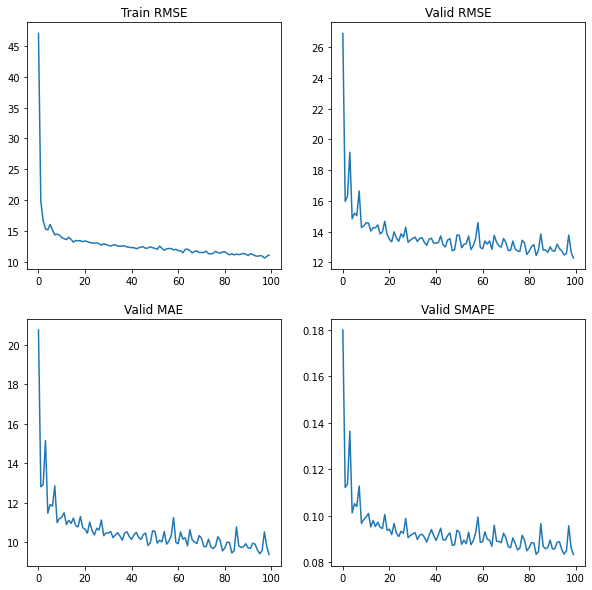

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history['Train Loss'])
axs[0, 0].title.set_text('Train RMSE')
axs[0, 1].plot(history['Valid RMSE'])
axs[0, 1].title.set_text('Valid RMSE')
axs[1, 0].plot(history['Valid MAE'])
axs[1, 0].title.set_text('Valid MAE')
axs[1, 1].plot(history['Valid SMAPE'])
axs[1, 1].title.set_text('Valid SMAPE')

In [22]:
test

NameError: name 'test' is not defined